# Security Threat Detection using Bayesian Gaussian Mixture Model (GMM) - Detect Unusual Login Activity

Created by John Ryan - 8th July 2025 - https://www.linkedin.com/in/john-ryan-da/

---

### Security Analysis Objective
---

#### Applying Bayesian Gaussian Mixtures Clustering unsupervised learning for Anomaly Detection when analysing login behavior such as unusual login hours, new geolocations, and failed attempts. 

__Steps Taken:__

1. Simulated authentication logs to mimic enterprise scenarios, applied feature engineering.
2. Data Preprocessing & Encoding
3. Apply a Bayesian Gaussian Mixture Model for Threat Detection.
4. Visualized anomalies using Cluster analysis with Seaborn and Matplotlib. 
5. Designed for use in security monitoring or SOC triage environments.

## Gaussian Mixture Model (GMM) In Security Detection
---

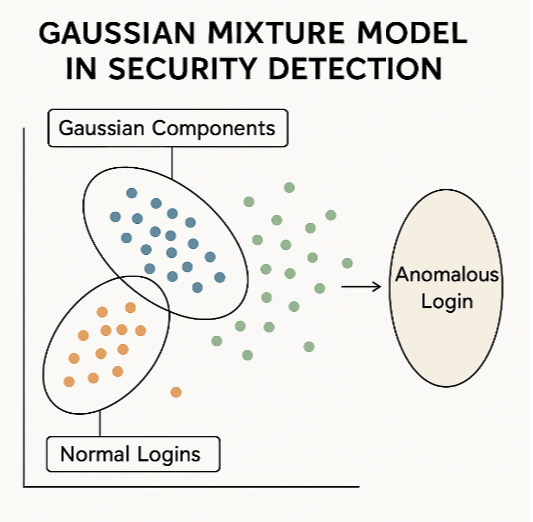

## What is a Gaussian Mixture Model
---

__A Gaussian Mixture Model is a way to model data as a mix of several bell-shaped (Gaussian) distributions.__

Imagine you’re looking at a scatterplot of login times for users, instead of assuming all the data is one big lump, you assume it’s made up of several smaller groups (clusters), each shaped like a bell curve.

Each group is described by:

* its mean (center),

* its variance (spread),

* its weight (how big it is compared to others).

## How it helps in Security Analyst Context
---

GMM uses probability, every data point belongs to each group to some degree (soft clustering), not just “yes/no”.

In security analytics like intrusion anomaly detection, you often need to identify patterns of normal behavior vs suspicious or outlier behavior.

* You collect features: login time, location, device type, IP, etc.

* You fit a GMM to model the normal behavior: it learns 2–3 clusters of typical login patterns (like “office hours at HQ” and “remote users at night”).

* Then you score new logins, If the probability of belonging to any cluster is very low, it’s an anomaly, possibly suspicious.

* If it fits cleanly into a cluster, it’s normal.

## Method
---

### 1. Simulated authentication logs to mimic enterprise scenarios, applied feature engineering.
---

In [1]:
import pandas as pd
data = pd.read_csv('/Users/johnryan/Downloads/Documents/Data Sets/dummy_syslog_login_events.csv')

In [2]:
data.describe()

,timestamp,user,ip,location,login_result
count,55,55,55,55,55
unique,52,3,47,5,2
top,2025-06-28 22:19:19,john,192.168.1.229,USA,success
freq,2,26,2,20,46


### 2. Data Preprocessing & Encoding

In [3]:
# convert data type from object to date time
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [4]:
#useful timestamp features for anomolies
data['hour'] = data['timestamp'].dt.hour
data['dayoftheweek'] = data['timestamp'].dt.dayofweek
data['minute'] = data['timestamp'].dt.minute


#Convert IP address to int
import ipaddress
data['ip_int'] = data['ip'].apply(lambda x: int(ipaddress.IPv4Address(x)))

                                  
#flag unusual regions outside of north america           
unusual_regions = ['China','Russia', 'UK']
data['unusual_region_flag'] = data['location'].map(lambda x: 1 if x in unusual_regions else 0)

                                  
#login result map fail = 1 else 0
data['login_result_flag'] = data['login_result'].str.lower().map({'fail': 1, 'success': 0})
                                  
#encode user + location categorical values to encode numeric representations
from sklearn.preprocessing import OrdinalEncoder
encoded_cat = ['user', 'location']
ordinal_encode = OrdinalEncoder()
data[encoded_cat] = ordinal_encode.fit_transform(data[encoded_cat])

data.head()

,timestamp,user,ip,location,login_result,hour,dayoftheweek,minute,ip_int,unusual_region_flag,login_result_flag
0,2025-06-28 18:59:19,2.0,192.168.1.229,3.0,success,18,5,59,3232236005,1,0
1,2025-06-28 19:09:19,2.0,192.168.1.224,3.0,success,19,5,9,3232236000,1,0
2,2025-06-28 19:19:19,0.0,192.168.1.212,3.0,success,19,5,19,3232235988,1,0
3,2025-06-28 19:29:19,2.0,192.168.1.254,0.0,success,19,5,29,3232236030,0,0
4,2025-06-28 19:39:19,0.0,192.168.1.72,4.0,success,19,5,39,3232235848,0,0


### 3. Apply a Bayesian Gaussian Mixture Model for Threat Detection
---

Here we fit the features to the GGM.

* Set n_components generously high, higher than the expected number of real clusters. If you think there are 5 behavior patterns, set n_components=10 or 20.
* The model will decide what number of clusters are needed. The Bayesian prior encourages the model to ignore unnecessary components, that’s the advantage of BGMM over a standard GMM.
* BGMM automatically gives low weights to unnecessary clusters.
* After fitting the model we get the weights, each weight tells you the proportion of the data that belongs to that cluster. This is important to generate as components with high weight represent dominant, normal behavior patterns.
* Look for components with very low weight, they may correspond to anomalous behaviors.

In [5]:
#Fit the model to the encoded features and apply the weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
features = data[['user', 'location', 'hour', 'dayoftheweek', 'minute', 'ip_int', 'unusual_region_flag', 'login_result_flag']]
bgm = BayesianGaussianMixture(n_components=20, n_init=10)
bgm.fit(features)
np.round(bgm.weights_, 2)
weights = np.round(bgm.weights_, 2)
weights

array([0.07, 0.05, 0.07, 0.02, 0.05, 0.06, 0.22, 0.12, 0.12, 0.05, 0.04,
       0.02, 0.02, 0.02, 0.02, 0.01, 0.02, 0.01, 0.01, 0.  ])

In [6]:
clusters = bgm.predict(features)
log_probs = bgm.score_samples(features)

# GMM Anomaly Visualization & Results
---
After you fit a BGMM to your feature data, you can calculate the log‑likelihood (log‑probability) of each data point under the learned model.

* Points with very low likelihood (compared to the rest of the data) are likely anomalies.
* Threshold, calculates the 5th percentile of all log‑probabilities.i.e I only trust the top 95% most likely points as normal, bottom 5% are anomalies.
* When the log probabalities are smaller than the threshold 5% these are the outliers.
* __3 outliers detected__

In [7]:
#This calculates the 5th percentile of all log‑probabilities.i.e I only trust the top 95% most likely points as normal.
threshold = np.percentile(log_probs, 5)  # bottom 5% are anomalies
outliers = log_probs < threshold

outlier_rows = data[outliers]
outlier_rows

,timestamp,user,ip,location,login_result,hour,dayoftheweek,minute,ip_int,unusual_region_flag,login_result_flag
35,2025-06-29 00:49:19,1.0,192.168.1.15,0.0,success,0,6,49,3232235791,0,0
46,2025-06-29 02:39:19,0.0,192.168.1.26,3.0,success,2,6,39,3232235802,1,0
50,2025-06-28 21:59:19,2.0,172.32.4.73,2.0,fail,21,5,59,2887779401,1,1


In [8]:
data['log_prob'] = log_probs
data_sorted = data.sort_values(by='log_prob')
print(data_sorted.head(3))  # 5 lowest likelihood points

             timestamp  user            ip  location login_result  hour  \
50 2025-06-28 21:59:19   2.0   172.32.4.73       2.0         fail    21   
35 2025-06-29 00:49:19   1.0  192.168.1.15       0.0      success     0   
46 2025-06-29 02:39:19   0.0  192.168.1.26       3.0      success     2   

    dayoftheweek  minute      ip_int  unusual_region_flag  login_result_flag  \
50             5      59  2887779401                    1                  1   
35             6      49  3232235791                    0                  0   
46             6      39  3232235802                    1                  0   

     log_prob  
50 -31.044403  
35 -30.806710  
46 -30.769763  


### Dimensionality Reduction using t-SNE (t-distributed Stochastic Neighbor Embedding)
---

Dimensionality Reduction is the process of reducing the number of features, to reduce training time and complexity in finding a good solution. Apart from speeding up training, dimensionality reduction is also useful for data visualization by reducing a high dimensional space to a 2D representation making it easy to plot a condensed data plane. In this solution we use t-SNE for visualising the outliers, t-SNE is an unsupervised non-linear dimensionality reduction technique for visualizing high-dimensional data. 
Non-linear dimensionality reduction means that the algorithm  allows us to separate data that cannot be separated by a straight line.

In [9]:
from sklearn.manifold import TSNE

features_2d = TSNE(n_components=2, random_state=42).fit_transform(features)

### GMM Clusters with 3 Total Outliers Highlighted
---

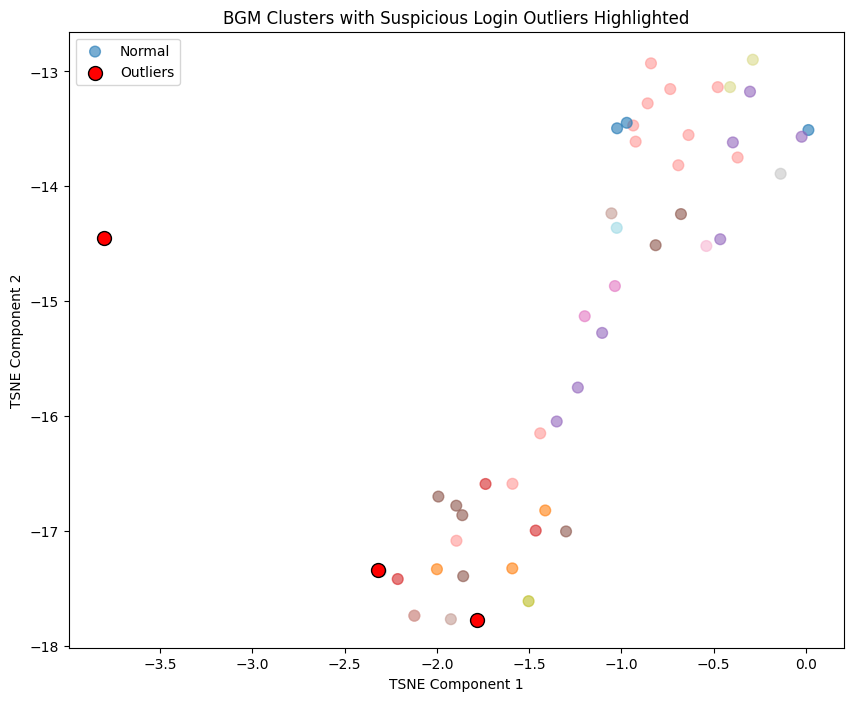

In [11]:
plt.figure(figsize=(10,8))

# Normal points
plt.scatter(
    features_2d[~outliers, 0], features_2d[~outliers, 1],
    c=clusters[~outliers], cmap='tab20', s=60, alpha=0.6, label='Normal'
)

# Outliers
plt.scatter(
    features_2d[outliers, 0], features_2d[outliers, 1],
    c='red', edgecolor='k', s=100, label='Outliers'
)

plt.title("BGM Clusters with Suspicious Login Outliers Highlighted")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend()
plt.show()

### End
----